<a href="https://colab.research.google.com/github/costpetrides/FAIRMODE-WG5/blob/main/BaseCASE_Shifted_Grids.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install folium

In [ ]:
pip install netCDF4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 30.4 MB/s eta 0:00:00


In [ ]:
pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 82.7 MB/s eta 0:00:00


# $O_{3}$

In [105]:
import xarray as xr
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm import tqdm

# --- Φόρτωση των αρχείων ---
nc_file_path = "BaseCase_PERT_O3_YEARLY.nc"
csv_file_path = "yearly_SURF_ppb_O3.csv"

# Φόρτωση του NetCDF
nc_data = xr.open_dataset(nc_file_path)

# Φόρτωση των συντεταγμένων του πλέγματος (ΓΩΝΙΕΣ των κελιών)
lon_values = nc_data["lon"].values
lat_values = nc_data["lat"].values

# Υπολογισμός του βήματος του πλέγματος (grid step)
lon_step = (lon_values[-1] - lon_values[0]) / (len(lon_values) - 1)
lat_step = (lat_values[-1] - lat_values[0]) / (len(lat_values) - 1)

#  Μετατροπή των συντεταγμένων από γωνίες σε ΚΕΝΤΡΑ κελιών
lon_centered = lon_values[:-1] + (lon_step / 2)
lat_centered = lat_values[:-1] + (lat_step / 2)

#  Δημιουργία νέου 2D πλέγματος με τις μετατοπισμένες τιμές
lon_grid, lat_grid = np.meshgrid(lon_centered, lat_centered)
grid_points_centered = np.column_stack((lon_grid.ravel(), lat_grid.ravel()))

# --- Φόρτωση των δεδομένων των σταθμών ---
station_data = pd.read_csv(csv_file_path)

# Ανάκτηση των συντεταγμένων των σταθμών
station_lons = station_data["lon"].values
station_lats = station_data["lat"].values
station_coords = np.column_stack((station_lons, station_lats))

#  Μετατροπή των συγκεντρώσεων O₃ από γωνίες σε κέντρα κελιών
o3_values_2D = nc_data["SURF_ppb_O3"].values.squeeze()

#  Δημιουργία KDTree για εύρεση πλησιέστερου σταθμού (ΒΕΛΤΙΩΣΗ ΑΠΟΔΟΣΗΣ)
station_tree = cKDTree(station_coords)

#  Εκτελούμε το query για όλα τα grid points ταυτόχρονα!
_, nearest_station_indices = station_tree.query(grid_points_centered)

#  Δημιουργούμε έναν πίνακα με τους πλησιέστερους σταθμούς για κάθε κελί
nearest_stations = station_coords[nearest_station_indices]

#  Ορισμός εύρους τιμών για βελτιστοποίηση
boost_factors = [1, 2, 3, 4, 5]  # Πόσο ενισχύουμε την επίδραση του πλησιέστερου σταθμού
beta_values = [1.5, 2, 2.5, 3, 3.5]  # Εκθέτης απόστασης (όσο μεγαλύτερο, τόσο λιγότερη επιρροή έχουν οι μακρινές γωνίες)

#  Αποθήκευση αποτελεσμάτων
results = []

# Προσθήκη progress bar
total_iterations = len(boost_factors) * len(beta_values)
with tqdm(total=total_iterations, desc="Βελτιστοποίηση Boost Factor & Beta") as pbar:

    for boost_factor in boost_factors:
        for beta in beta_values:
            o3_centered = np.zeros((len(lat_centered), len(lon_centered)))

            for i in range(len(lat_centered)):
                for j in range(len(lon_centered)):
                    #  Αντί να καλούμε query(), παίρνουμε απευθείας τον πλησιέστερο σταθμό
                    nearest_station = nearest_stations[i * len(lon_centered) + j]

                    # Συντεταγμένες γωνιών του κελιού
                    corners = np.array([
                        [lon_values[j], lat_values[i]],     # Πάνω αριστερά
                        [lon_values[j+1], lat_values[i]],   # Πάνω δεξιά
                        [lon_values[j], lat_values[i+1]],   # Κάτω αριστερά
                        [lon_values[j+1], lat_values[i+1]]  # Κάτω δεξιά
                    ])

                    # Συγκεντρώσεις στις γωνίες
                    values = np.array([
                        o3_values_2D[i, j],
                        o3_values_2D[i, j+1],
                        o3_values_2D[i+1, j],
                        o3_values_2D[i+1, j+1]
                    ])

                    # Υπολογίζουμε αποστάσεις κάθε γωνίας από τον πλησιέστερο σταθμό
                    dists_to_station = np.linalg.norm(corners - nearest_station, axis=1)

                    # Αντίστροφα βάρη (IDW-like)
                    weights = 1 / (dists_to_station**beta)

                    # Βρίσκουμε ποια γωνία είναι η πλησιέστερη στον σταθμό
                    closest_corner_idx = np.argmin(dists_to_station)

                    # Αυξάνουμε το βάρος της πλησιέστερης γωνίας
                    weights[closest_corner_idx] *= boost_factor

                    # Κανονικοποίηση των βαρών
                    weights /= np.sum(weights)

                    # Υπολογισμός σταθμισμένου μέσου όρου
                    o3_centered[i, j] = np.sum(weights * values)

            #  Υπολογισμός σφαλμάτων
            o3_centered_1D = o3_centered.ravel()
            tree_centered = cKDTree(grid_points_centered)
            distances, indices = tree_centered.query(station_coords)

            nearest_o3 = o3_centered_1D[indices]
            observed_O3 = station_data["SURF_ppb_O3"].values

            mae = mean_absolute_error(observed_O3, nearest_o3)
            rmse = np.sqrt(mean_squared_error(observed_O3, nearest_o3))

            results.append((boost_factor, beta, mae, rmse))

            #  Ενημέρωση progress bar
            pbar.update(1)

#  Μετατροπή αποτελεσμάτων σε DataFrame
df_results = pd.DataFrame(results, columns=["Boost Factor", "Beta", "MAE", "RMSE"])
df_results.to_csv("best_model_results.csv", index=False)
print("\nΤα αποτελέσματα αποθηκεύτηκαν στο best_model_results.csv")

# Βρίσκουμε το καλύτερο μοντέλο (χαμηλότερο RMSE)
best_model = df_results.loc[df_results["RMSE"].idxmin()]
print(f"\n Best Model Found: Boost Factor = {best_model['Boost Factor']}, Beta = {best_model['Beta']}")
print(f"MAE = {best_model['MAE']:.4f}, RMSE = {best_model['RMSE']:.4f}")


#  Δημιουργία του αρχείου matched_O3_optimized.csv
df_matched = pd.DataFrame({
    "lon": station_lons,
    "lat": station_lats,
    "SURF_ppb_O3": station_data["SURF_ppb_O3"].values,
    "nearest_lon": grid_points_centered[indices, 0],
    "nearest_lat": grid_points_centered[indices, 1],
    "nearest_SURF_ppb_O3": nearest_o3
})

df_matched.to_csv("matched_O3_optimized.csv", index=False)
print("Το αρχείο αντιστοιχίσεων αποθηκεύτηκε ως: matched_O3_optimized.csv")


Βελτιστοποίηση Boost Factor & Beta: 100%|██████████| 25/25 [04:50<00:00, 11.61s/it]


Τα αποτελέσματα αποθηκεύτηκαν στο best_model_results.csv
Το αρχείο αντιστοιχίσεων αποθηκεύτηκε ως: matched_O3_optimized.csv


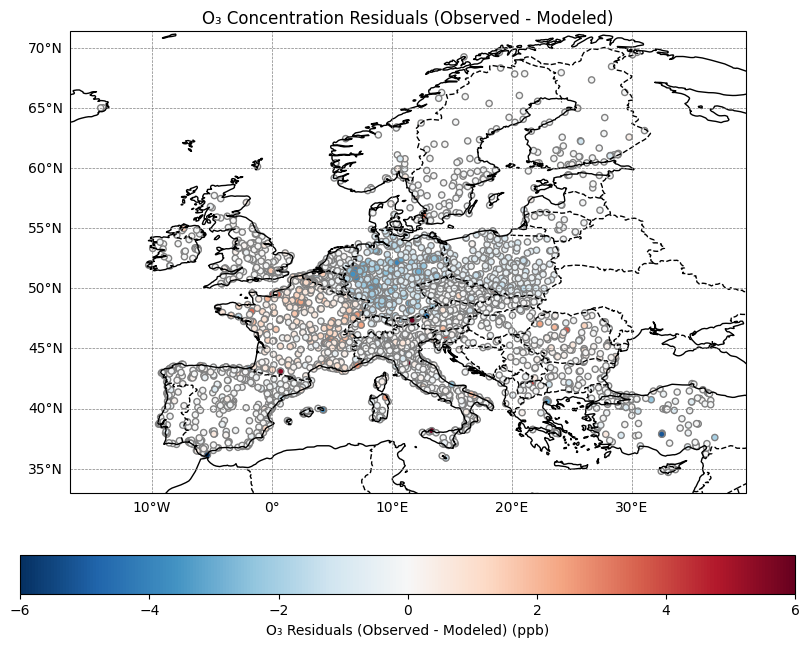

In [107]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd

# Φόρτωση των δεδομένων
stations = pd.read_csv("matched_O3_optimized.csv")

# Υπολογισμός των residuals ως (Observed - Modeled)
stations["O3_residuals"] = stations["SURF_ppb_O3"] - stations["nearest_SURF_ppb_O3"]

# Ορισμός των ορίων της χρωματικής κλίμακας
cbar_min = -6
cbar_max = 6

# Δημιουργία χάρτη
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": ccrs.PlateCarree()})

# Προσθήκη συνόρων και ακτογραμμών
ax.add_feature(cfeature.BORDERS, linestyle="--", edgecolor="black", linewidth=1)
ax.coastlines(resolution="50m", linewidth=1)

# Προσθήκη γραμμών πλέγματος
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray")
gl.top_labels = False  # Αφαίρεση ετικετών στην κορυφή
gl.right_labels = False  # Αφαίρεση ετικετών στα δεξιά

# Προβολή των residuals O₃ με χρωματική κλίμακα RdBu (το 0 στο λευκό)
sc = ax.scatter(
    stations["lon"],
    stations["lat"],
    c=stations["O3_residuals"],
    cmap="RdBu_r",
    vmin=cbar_min,
    vmax=cbar_max,
    edgecolors= "grey",
    s=20,
    transform=ccrs.PlateCarree()
)

# Προσθήκη οριζόντιας χρωματικής κλίμακας κάτω από το σχήμα
cbar = plt.colorbar(sc, ax=ax, orientation="horizontal", pad=0.1)
cbar.set_label("O₃ Residuals (Observed - Modeled) (ppb)")

# Τίτλος
ax.set_title("O₃ Concentration Residuals (Observed - Modeled)")

# Εμφάνιση χάρτη
plt.show()


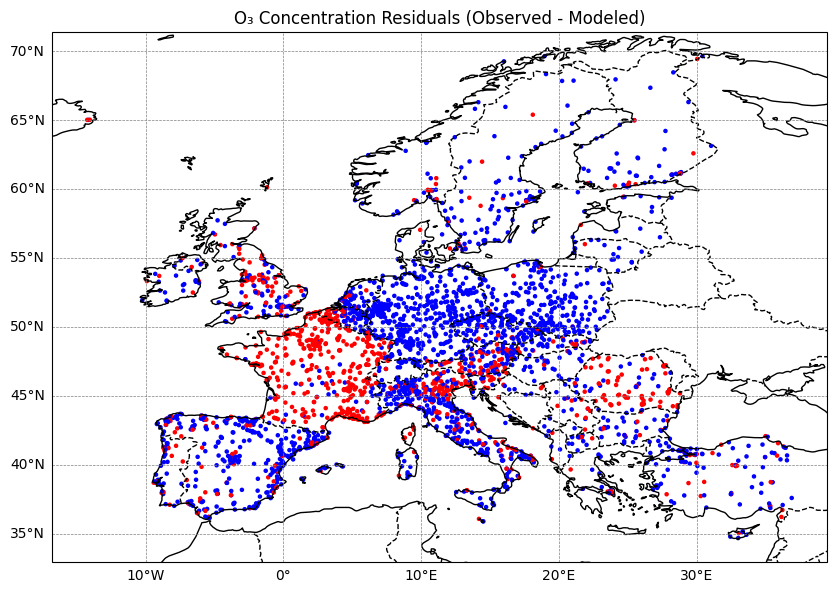

In [109]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd

# Φόρτωση των δεδομένων
stations = pd.read_csv("matched_O3_optimized.csv")

# Υπολογισμός των residuals ως (Observed - Modeled)
stations["O3_residuals"] = stations["SURF_ppb_O3"] - stations["nearest_SURF_ppb_O3"]

# Ορισμός χρώματος ανάλογα με το πρόσημο των residuals
colors = stations["O3_residuals"].apply(lambda x: "red" if x > 0 else "blue")

# Δημιουργία χάρτη
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": ccrs.PlateCarree()})

# Προσθήκη συνόρων και ακτογραμμών
ax.add_feature(cfeature.BORDERS, linestyle="--", edgecolor="black", linewidth=1)
ax.coastlines(resolution="50m", linewidth=1)

# Προσθήκη γραμμών πλέγματος
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray")
gl.top_labels = False  # Αφαίρεση ετικετών στην κορυφή
gl.right_labels = False  # Αφαίρεση ετικετών στα δεξιά

# Προβολή των residuals O₃ με δύο χρώματα (μπλε = θετικά, κόκκινο = αρνητικά)
sc = ax.scatter(
    stations["lon"],
    stations["lat"],
    c=colors,
    edgecolors=None,
    s=5,  # Σταθερό μέγεθος σημείων
    transform=ccrs.PlateCarree()
)


# Τίτλος
ax.set_title("O₃ Concentration Residuals (Observed - Modeled)")

# Εμφάνιση χάρτη
plt.show()

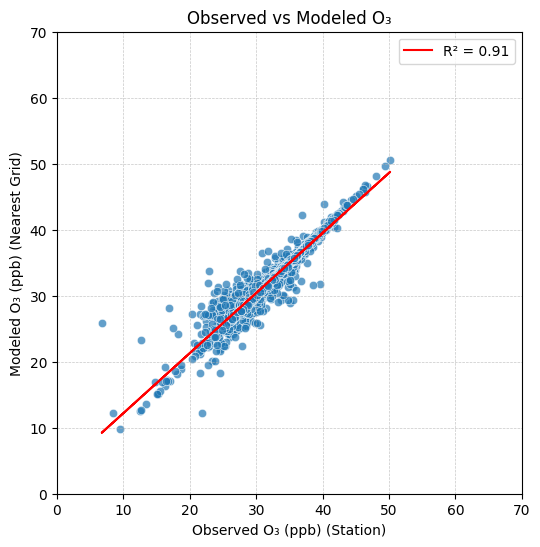

Mean Absolute Error (MAE): 0.68
Root Mean Squared Error (RMSE): 1.30


In [110]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress
from sklearn.metrics import mean_absolute_error, mean_squared_error  # Import missing functions

# Load the dataset
stations = pd.read_csv("matched_O3_optimized.csv")

# Extract observed and modeled PM2.5 values
observed_O3 = stations["SURF_ppb_O3"]
modeled_O3 = stations["nearest_SURF_ppb_O3"]

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(observed_O3, modeled_O3)

# Calculate R-squared
r_squared = r_value**2

# Create the scatter plot with grid
plt.figure(figsize=(6, 6))
sns.scatterplot(x=observed_O3, y=modeled_O3, alpha=0.7)

# Plot the regression line with R² label
plt.plot(observed_O3, slope * observed_O3 + intercept, color='red', label=f"R² = {r_squared:.2f}")

# Labels, title, and grid
plt.xlabel("Observed O₃ (ppb) (Station)")
plt.xlim(0, 70)
plt.ylim(0, 70)
plt.ylabel("Modeled O₃ (ppb) (Nearest Grid)")
plt.title("Observed vs Modeled O₃")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

# Show the plot
plt.show()

# Compute error metrics
mae = mean_absolute_error(observed_O3, modeled_O3)
rmse = np.sqrt(mean_squared_error(observed_O3, modeled_O3))

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# $NO_{2}$

In [112]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm import tqdm

# --- Φόρτωση των αρχείων ---
nc_file_path = "BaseCase_PERT_NO2_YEARLY.nc"
csv_file_path = "yearly_SURF_ug_NO2.csv"

# Φόρτωση του NetCDF
nc_data = xr.open_dataset(nc_file_path)

# Φόρτωση των συντεταγμένων του πλέγματος (ΓΩΝΙΕΣ των κελιών)
lon_values = nc_data["lon"].values
lat_values = nc_data["lat"].values

# Υπολογισμός του βήματος του πλέγματος (grid step)
lon_step = (lon_values[-1] - lon_values[0]) / (len(lon_values) - 1)
lat_step = (lat_values[-1] - lat_values[0]) / (len(lat_values) - 1)

# Μετατροπή των συντεταγμένων από γωνίες σε ΚΕΝΤΡΑ κελιών
lon_centered = lon_values[:-1] + (lon_step / 2)
lat_centered = lat_values[:-1] + (lat_step / 2)

# Δημιουργία νέου 2D πλέγματος με τις μετατοπισμένες τιμές
lon_grid, lat_grid = np.meshgrid(lon_centered, lat_centered)
grid_points_centered = np.column_stack((lon_grid.ravel(), lat_grid.ravel()))

# --- Φόρτωση των δεδομένων των σταθμών ---
station_data = pd.read_csv(csv_file_path)

# Ανάκτηση των συντεταγμένων των σταθμών
station_lons = station_data["lon"].values
station_lats = station_data["lat"].values
station_coords = np.column_stack((station_lons, station_lats))

# Μετατροπή των συγκεντρώσεων NO₂ από γωνίες σε κέντρα κελιών
no2_values_2D = nc_data["SURF_ug_NO2"].values.squeeze()

# Δημιουργία KDTree για εύρεση πλησιέστερου σταθμού
station_tree = cKDTree(station_coords)

# Εκτελούμε το query για όλα τα grid points ταυτόχρονα!
_, nearest_station_indices = station_tree.query(grid_points_centered)

# Δημιουργούμε έναν πίνακα με τους πλησιέστερους σταθμούς για κάθε κελί
nearest_stations = station_coords[nearest_station_indices]

# Ορισμός εύρους τιμών για βελτιστοποίηση
boost_factors = [1, 2, 3, 4, 5]  # Ενίσχυση πλησιέστερου σταθμού
beta_values = [1.5, 2, 2.5, 3, 3.5]  # Εκθέτης απόστασης

# Αποθήκευση αποτελεσμάτων
results = []

# Προσθήκη progress bar
total_iterations = len(boost_factors) * len(beta_values)
with tqdm(total=total_iterations, desc="Βελτιστοποίηση Boost Factor & Beta") as pbar:

    for boost_factor in boost_factors:
        for beta in beta_values:
            no2_centered = np.zeros((len(lat_centered), len(lon_centered)))

            for i in range(len(lat_centered)):
                for j in range(len(lon_centered)):
                    # Αντί να καλούμε query(), παίρνουμε απευθείας τον πλησιέστερο σταθμό
                    nearest_station = nearest_stations[i * len(lon_centered) + j]

                    # Συντεταγμένες γωνιών του κελιού
                    corners = np.array([
                        [lon_values[j], lat_values[i]],     # Πάνω αριστερά
                        [lon_values[j+1], lat_values[i]],   # Πάνω δεξιά
                        [lon_values[j], lat_values[i+1]],   # Κάτω αριστερά
                        [lon_values[j+1], lat_values[i+1]]  # Κάτω δεξιά
                    ])

                    # Συγκεντρώσεις στις γωνίες
                    values = np.array([
                        no2_values_2D[i, j],
                        no2_values_2D[i, j+1],
                        no2_values_2D[i+1, j],
                        no2_values_2D[i+1, j+1]
                    ])

                    # Υπολογίζουμε αποστάσεις κάθε γωνίας από τον πλησιέστερο σταθμό
                    dists_to_station = np.linalg.norm(corners - nearest_station, axis=1)

                    # Αντίστροφα βάρη (IDW-like)
                    weights = 1 / (dists_to_station**beta)

                    # Βρίσκουμε ποια γωνία είναι η πλησιέστερη στον σταθμό
                    closest_corner_idx = np.argmin(dists_to_station)

                    # Αυξάνουμε το βάρος της πλησιέστερης γωνίας
                    weights[closest_corner_idx] *= boost_factor

                    # Κανονικοποίηση των βαρών
                    weights /= np.sum(weights)

                    # Υπολογισμός σταθμισμένου μέσου όρου
                    no2_centered[i, j] = np.sum(weights * values)

            # Υπολογισμός σφαλμάτων
            no2_centered_1D = no2_centered.ravel()
            tree_centered = cKDTree(grid_points_centered)
            distances, indices = tree_centered.query(station_coords)

            nearest_no2 = no2_centered_1D[indices]
            observed_NO2 = station_data["SURF_ug_NO2"].values

            mae = mean_absolute_error(observed_NO2, nearest_no2)
            rmse = np.sqrt(mean_squared_error(observed_NO2, nearest_no2))

            results.append((boost_factor, beta, mae, rmse))

            # Ενημέρωση progress bar
            pbar.update(1)

# Μετατροπή αποτελεσμάτων σε DataFrame
df_results = pd.DataFrame(results, columns=["Boost Factor", "Beta", "MAE", "RMSE"])
df_results.to_csv("best_model_results_NO2.csv", index=False)
print("\nΤα αποτελέσματα αποθηκεύτηκαν στο best_model_results_NO2.csv")

# Βρίσκουμε το καλύτερο μοντέλο (χαμηλότερο RMSE)
best_model = df_results.loc[df_results["RMSE"].idxmin()]
print(f"\n Best Model Found: Boost Factor = {best_model['Boost Factor']}, Beta = {best_model['Beta']}")
print(f"MAE = {best_model['MAE']:.4f}, RMSE = {best_model['RMSE']:.4f}")


# Δημιουργία του αρχείου matched_NO2_optimized.csv
df_matched = pd.DataFrame({
    "lon": station_lons,
    "lat": station_lats,
    "SURF_ug_NO2": station_data["SURF_ug_NO2"].values,
    "nearest_lon": grid_points_centered[indices, 0],
    "nearest_lat": grid_points_centered[indices, 1],
    "nearest_SURF_ug_NO2": nearest_no2
})

df_matched.to_csv("matched_NO2_optimized.csv", index=False)
print("Το αρχείο αντιστοιχίσεων αποθηκεύτηκε ως: matched_NO2_optimized.csv")

Βελτιστοποίηση Boost Factor & Beta: 100%|██████████| 25/25 [04:49<00:00, 11.59s/it]


Τα αποτελέσματα αποθηκεύτηκαν στο best_model_results_NO2.csv
Το αρχείο αντιστοιχίσεων αποθηκεύτηκε ως: matched_NO2_optimized.csv


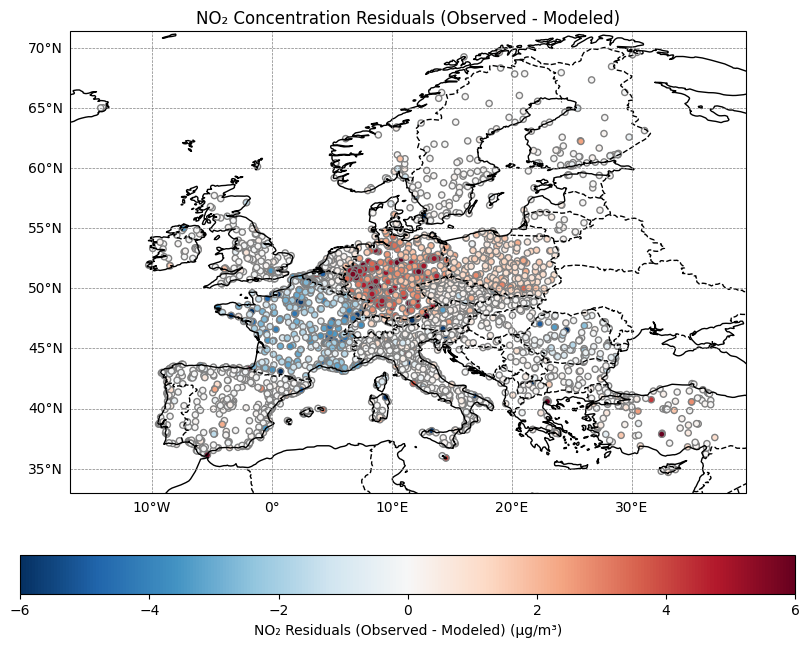

In [113]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd

# Φόρτωση των δεδομένων
stations = pd.read_csv("matched_NO2_optimized.csv")

# Υπολογισμός των residuals ως (Observed - Modeled)
stations["NO2_residuals"] = stations["SURF_ug_NO2"] - stations["nearest_SURF_ug_NO2"]

# Ορισμός των ορίων της χρωματικής κλίμακας
cbar_min = -6
cbar_max = 6

# Δημιουργία χάρτη
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": ccrs.PlateCarree()})

# Προσθήκη συνόρων και ακτογραμμών
ax.add_feature(cfeature.BORDERS, linestyle="--", edgecolor="black", linewidth=1)
ax.coastlines(resolution="50m", linewidth=1)

# Προσθήκη γραμμών πλέγματος
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray")
gl.top_labels = False  # Αφαίρεση ετικετών στην κορυφή
gl.right_labels = False  # Αφαίρεση ετικετών στα δεξιά

# Προβολή των residuals NO₂ με χρωματική κλίμακα RdBu (το 0 στο λευκό)
sc = ax.scatter(
    stations["lon"],
    stations["lat"],
    c=stations["NO2_residuals"],
    cmap="RdBu_r",
    vmin=cbar_min,
    vmax=cbar_max,
    edgecolors= "grey",
    s=20,
    transform=ccrs.PlateCarree()
)

# Προσθήκη οριζόντιας χρωματικής κλίμακας κάτω από το σχήμα
cbar = plt.colorbar(sc, ax=ax, orientation="horizontal", pad=0.1)
cbar.set_label("NO₂ Residuals (Observed - Modeled) (µg/m³)")

# Τίτλος
ax.set_title("NO₂ Concentration Residuals (Observed - Modeled)")

# Εμφάνιση χάρτη
plt.show()

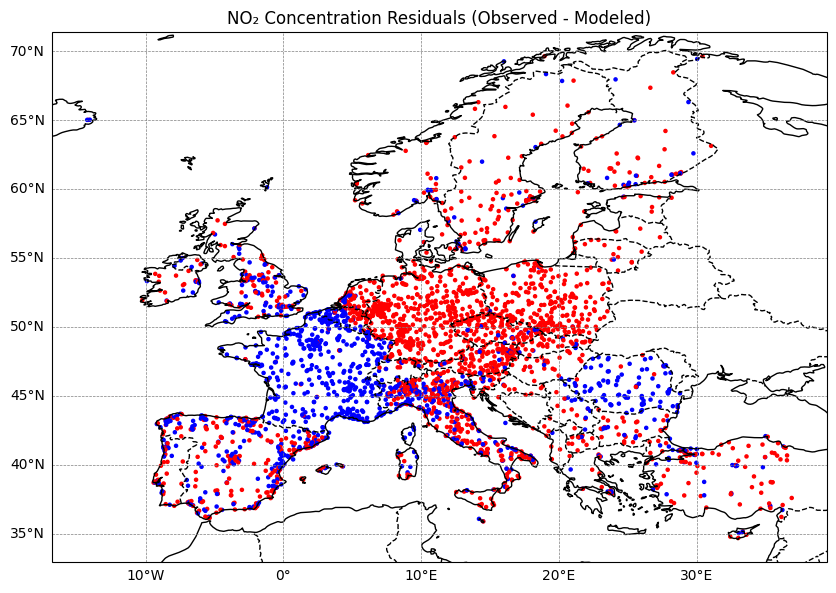

In [114]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd

# Φόρτωση των δεδομένων
stations = pd.read_csv("matched_NO2_optimized.csv")

# Υπολογισμός των residuals ως (Observed - Modeled)
stations["NO2_residuals"] = stations["SURF_ug_NO2"] - stations["nearest_SURF_ug_NO2"]

# Ορισμός χρώματος ανάλογα με το πρόσημο των residuals
colors = stations["NO2_residuals"].apply(lambda x: "red" if x > 0 else "blue")

# Δημιουργία χάρτη
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": ccrs.PlateCarree()})

# Προσθήκη συνόρων και ακτογραμμών
ax.add_feature(cfeature.BORDERS, linestyle="--", edgecolor="black", linewidth=1)
ax.coastlines(resolution="50m", linewidth=1)

# Προσθήκη γραμμών πλέγματος
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray")
gl.top_labels = False  # Αφαίρεση ετικετών στην κορυφή
gl.right_labels = False  # Αφαίρεση ετικετών στα δεξιά

# Προβολή των residuals O₃ με δύο χρώματα (μπλε = θετικά, κόκκινο = αρνητικά)
sc = ax.scatter(
    stations["lon"],
    stations["lat"],
    c=colors,
    edgecolors=None,
    s=5,  # Σταθερό μέγεθος σημείων
    transform=ccrs.PlateCarree()
)

# Τίτλος
ax.set_title("NO₂ Concentration Residuals (Observed - Modeled)")

# Εμφάνιση χάρτη
plt.show()

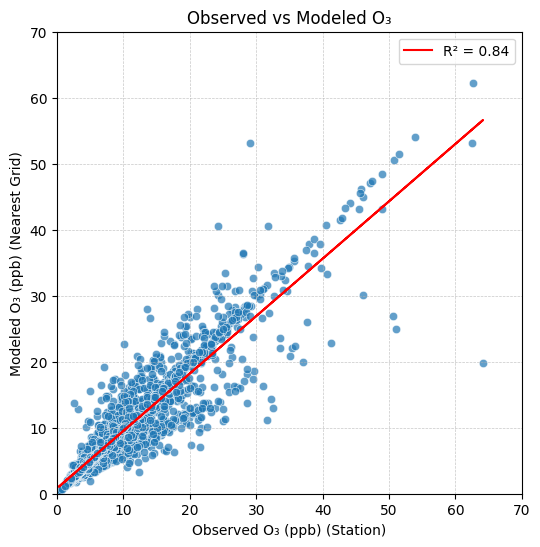

Mean Absolute Error (MAE): 1.54
Root Mean Squared Error (RMSE): 2.99


In [117]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress
from sklearn.metrics import mean_absolute_error, mean_squared_error  # Import missing functions

# Load the dataset
stations = pd.read_csv("matched_NO2_optimized.csv")

# Extract observed and modeled PM2.5 values
observed_O3 = stations["SURF_ug_NO2"]
modeled_O3 = stations["nearest_SURF_ug_NO2"]

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(observed_O3, modeled_O3)

# Calculate R-squared
r_squared = r_value**2

# Create the scatter plot with grid
plt.figure(figsize=(6, 6))
sns.scatterplot(x=observed_O3, y=modeled_O3, alpha=0.7)

# Plot the regression line with R² label
plt.plot(observed_O3, slope * observed_O3 + intercept, color='red', label=f"R² = {r_squared:.2f}")

# Labels, title, and grid
plt.xlabel("Observed O₃ (ppb) (Station)")
plt.xlim(0, 70)
plt.ylim(0, 70)
plt.ylabel("Modeled O₃ (ppb) (Nearest Grid)")
plt.title("Observed vs Modeled O₃")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

# Show the plot
plt.show()

# Compute error metrics
mae = mean_absolute_error(observed_O3, modeled_O3)
rmse = np.sqrt(mean_squared_error(observed_O3, modeled_O3))

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# $PM_{2.5}$

In [118]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm import tqdm

# --- Φόρτωση των αρχείων ---
nc_file_path = "BaseCase_PERT_PM25_rh50_YEARLY.nc"
csv_file_path = "yearly_SURF_ug_PM25_rh50.csv"

# Φόρτωση του NetCDF
nc_data = xr.open_dataset(nc_file_path)

# Φόρτωση των συντεταγμένων του πλέγματος (ΓΩΝΙΕΣ των κελιών)
lon_values = nc_data["lon"].values
lat_values = nc_data["lat"].values

# Υπολογισμός του βήματος του πλέγματος (grid step)
lon_step = (lon_values[-1] - lon_values[0]) / (len(lon_values) - 1)
lat_step = (lat_values[-1] - lat_values[0]) / (len(lat_values) - 1)

# Μετατροπή των συντεταγμένων από γωνίες σε ΚΕΝΤΡΑ κελιών
lon_centered = lon_values[:-1] + (lon_step / 2)
lat_centered = lat_values[:-1] + (lat_step / 2)

# Δημιουργία νέου 2D πλέγματος με τις μετατοπισμένες τιμές
lon_grid, lat_grid = np.meshgrid(lon_centered, lat_centered)
grid_points_centered = np.column_stack((lon_grid.ravel(), lat_grid.ravel()))

# --- Φόρτωση των δεδομένων των σταθμών ---
station_data = pd.read_csv(csv_file_path)

# Ανάκτηση των συντεταγμένων των σταθμών
station_lons = station_data["lon"].values
station_lats = station_data["lat"].values
station_coords = np.column_stack((station_lons, station_lats))

# Μετατροπή των συγκεντρώσεων PM₂.₅ από γωνίες σε κέντρα κελιών
pm25_values_2D = nc_data["SURF_ug_PM25_rh50"].values.squeeze()

# Δημιουργία KDTree για εύρεση πλησιέστερου σταθμού
station_tree = cKDTree(station_coords)

# Εκτελούμε το query για όλα τα grid points ταυτόχρονα!
_, nearest_station_indices = station_tree.query(grid_points_centered)

# Δημιουργούμε έναν πίνακα με τους πλησιέστερους σταθμούς για κάθε κελί
nearest_stations = station_coords[nearest_station_indices]

# Ορισμός εύρους τιμών για βελτιστοποίηση
boost_factors = [1, 2, 3, 4, 5]  # Ενίσχυση πλησιέστερου σταθμού
beta_values = [1.5, 2, 2.5, 3, 3.5]  # Εκθέτης απόστασης

# Αποθήκευση αποτελεσμάτων
results = []

# Προσθήκη progress bar
total_iterations = len(boost_factors) * len(beta_values)
with tqdm(total=total_iterations, desc="Βελτιστοποίηση Boost Factor & Beta") as pbar:

    for boost_factor in boost_factors:
        for beta in beta_values:
            pm25_centered = np.zeros((len(lat_centered), len(lon_centered)))

            for i in range(len(lat_centered)):
                for j in range(len(lon_centered)):
                    # Αντί να καλούμε query(), παίρνουμε απευθείας τον πλησιέστερο σταθμό
                    nearest_station = nearest_stations[i * len(lon_centered) + j]

                    # Συντεταγμένες γωνιών του κελιού
                    corners = np.array([
                        [lon_values[j], lat_values[i]],     # Πάνω αριστερά
                        [lon_values[j+1], lat_values[i]],   # Πάνω δεξιά
                        [lon_values[j], lat_values[i+1]],   # Κάτω αριστερά
                        [lon_values[j+1], lat_values[i+1]]  # Κάτω δεξιά
                    ])

                    # Συγκεντρώσεις στις γωνίες
                    values = np.array([
                        pm25_values_2D[i, j],
                        pm25_values_2D[i, j+1],
                        pm25_values_2D[i+1, j],
                        pm25_values_2D[i+1, j+1]
                    ])

                    # Υπολογίζουμε αποστάσεις κάθε γωνίας από τον πλησιέστερο σταθμό
                    dists_to_station = np.linalg.norm(corners - nearest_station, axis=1)

                    # Αντίστροφα βάρη (IDW-like)
                    weights = 1 / (dists_to_station**beta)

                    # Βρίσκουμε ποια γωνία είναι η πλησιέστερη στον σταθμό
                    closest_corner_idx = np.argmin(dists_to_station)

                    # Αυξάνουμε το βάρος της πλησιέστερης γωνίας
                    weights[closest_corner_idx] *= boost_factor

                    # Κανονικοποίηση των βαρών
                    weights /= np.sum(weights)

                    # Υπολογισμός σταθμισμένου μέσου όρου
                    pm25_centered[i, j] = np.sum(weights * values)

            # Υπολογισμός σφαλμάτων
            pm25_centered_1D = pm25_centered.ravel()
            tree_centered = cKDTree(grid_points_centered)
            distances, indices = tree_centered.query(station_coords)

            nearest_pm25 = pm25_centered_1D[indices]
            observed_PM25 = station_data["SURF_ug_PM25_rh50"].values

            mae = mean_absolute_error(observed_PM25, nearest_pm25)
            rmse = np.sqrt(mean_squared_error(observed_PM25, nearest_pm25))

            results.append((boost_factor, beta, mae, rmse))

            # Ενημέρωση progress bar
            pbar.update(1)

# Μετατροπή αποτελεσμάτων σε DataFrame
df_results = pd.DataFrame(results, columns=["Boost Factor", "Beta", "MAE", "RMSE"])
df_results.to_csv("best_model_results_PM25.csv", index=False)

# Βρίσκουμε το καλύτερο μοντέλο (χαμηλότερο RMSE)
best_model = df_results.loc[df_results["RMSE"].idxmin()]
print(f"\n Best Model Found: Boost Factor = {best_model['Boost Factor']}, Beta = {best_model['Beta']}")
print(f"MAE = {best_model['MAE']:.4f}, RMSE = {best_model['RMSE']:.4f}")

# Δημιουργία του αρχείου matched_PM25_optimized.csv
df_matched = pd.DataFrame({
    "lon": station_lons,
    "lat": station_lats,
    "SURF_ug_PM25_rh50": station_data["SURF_ug_PM25_rh50"].values,
    "nearest_lon": grid_points_centered[indices, 0],
    "nearest_lat": grid_points_centered[indices, 1],
    "nearest_SURF_ug_PM25_rh50": nearest_pm25
})

df_matched.to_csv("matched_PM25_optimized.csv", index=False)
print("Το αρχείο αντιστοιχίσεων αποθηκεύτηκε ως: matched_PM25_optimized.csv")


Βελτιστοποίηση Boost Factor & Beta: 100%|██████████| 25/25 [04:45<00:00, 11.41s/it]


 Best Model Found: Boost Factor = 5.0, Beta = 3.5
MAE = 0.9879, RMSE = 1.9434
Το αρχείο αντιστοιχίσεων αποθηκεύτηκε ως: matched_PM25_optimized.csv


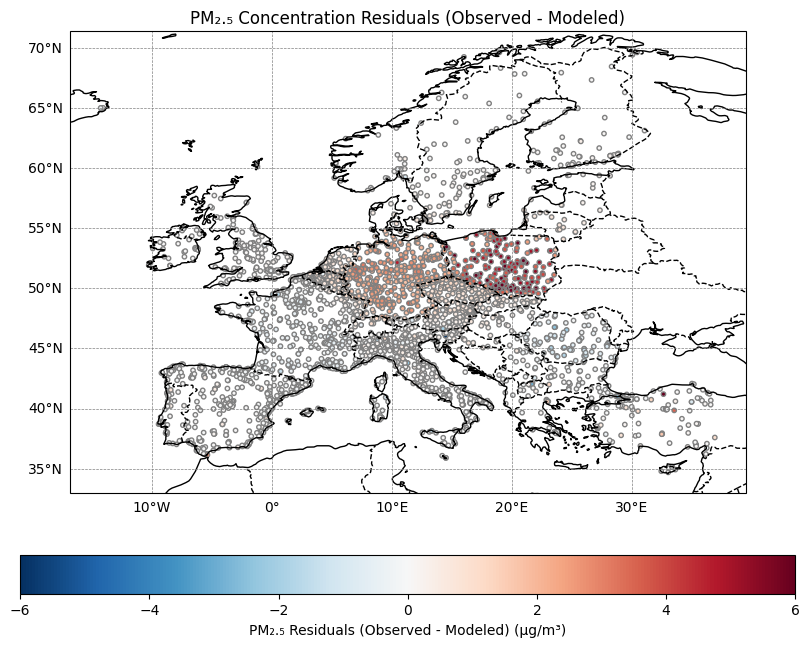

In [119]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd

# Φόρτωση των δεδομένων
stations = pd.read_csv("matched_PM25_optimized.csv")

# Υπολογισμός των residuals ως (Observed - Modeled)
stations["PM25_residuals"] = stations["SURF_ug_PM25_rh50"] - stations["nearest_SURF_ug_PM25_rh50"]

# Ορισμός των ορίων της χρωματικής κλίμακας
cbar_min = -6
cbar_max = 6

# Δημιουργία χάρτη
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": ccrs.PlateCarree()})

# Προσθήκη συνόρων και ακτογραμμών
ax.add_feature(cfeature.BORDERS, linestyle="--", edgecolor="black", linewidth=1)
ax.coastlines(resolution="50m", linewidth=1)

# Προσθήκη γραμμών πλέγματος
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray")
gl.top_labels = False  # Αφαίρεση ετικετών στην κορυφή
gl.right_labels = False  # Αφαίρεση ετικετών στα δεξιά

# Προβολή των residuals NO₂ με χρωματική κλίμακα RdBu (το 0 στο λευκό)
sc = ax.scatter(
    stations["lon"],
    stations["lat"],
    c=stations["PM25_residuals"],
    cmap="RdBu_r",
    vmin=cbar_min,
    vmax=cbar_max,
    edgecolors= "grey",
    s=10,
    transform=ccrs.PlateCarree()
)

# Προσθήκη οριζόντιας χρωματικής κλίμακας κάτω από το σχήμα
cbar = plt.colorbar(sc, ax=ax, orientation="horizontal", pad=0.1)
cbar.set_label("PM₂.₅ Residuals (Observed - Modeled) (µg/m³)")

# Τίτλος
ax.set_title("PM₂.₅ Concentration Residuals (Observed - Modeled)")

# Εμφάνιση χάρτη
plt.show()

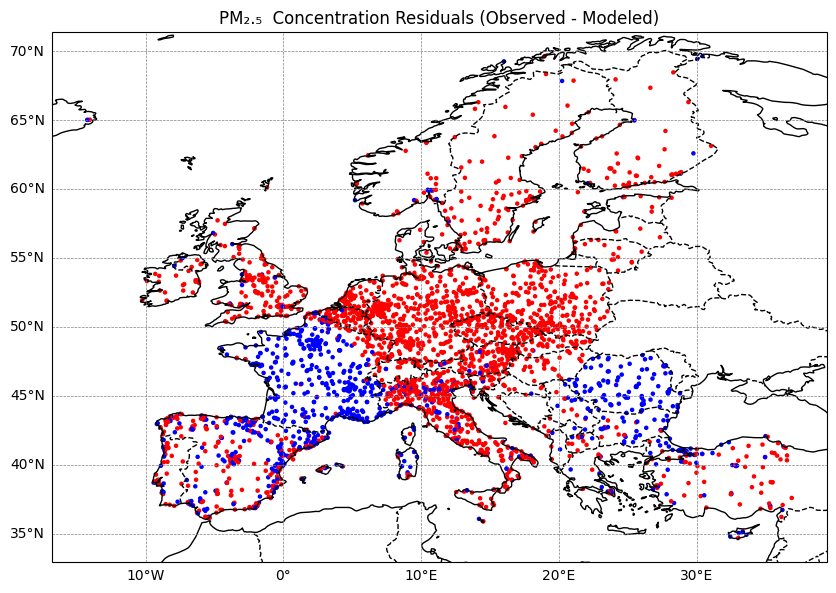

In [120]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd

# Φόρτωση των δεδομένων
stations = pd.read_csv("matched_PM25_optimized.csv")

# Υπολογισμός των residuals ως (Observed - Modeled)
stations["PM25_residuals"] = stations["SURF_ug_PM25_rh50"] - stations["nearest_SURF_ug_PM25_rh50"]

# Ορισμός χρώματος ανάλογα με το πρόσημο των residuals
colors = stations["PM25_residuals"].apply(lambda x: "red" if x > 0 else "blue")

# Δημιουργία χάρτη
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": ccrs.PlateCarree()})

# Προσθήκη συνόρων και ακτογραμμών
ax.add_feature(cfeature.BORDERS, linestyle="--", edgecolor="black", linewidth=1)
ax.coastlines(resolution="50m", linewidth=1)

# Προσθήκη γραμμών πλέγματος
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray")
gl.top_labels = False  # Αφαίρεση ετικετών στην κορυφή
gl.right_labels = False  # Αφαίρεση ετικετών στα δεξιά

# Προβολή των residuals O₃ με δύο χρώματα (μπλε = θετικά, κόκκινο = αρνητικά)
sc = ax.scatter(
    stations["lon"],
    stations["lat"],
    c=colors,
    edgecolors=None,
    s=5,  # Σταθερό μέγεθος σημείων
    transform=ccrs.PlateCarree()
)


# Τίτλος
ax.set_title("PM₂.₅  Concentration Residuals (Observed - Modeled)")

# Εμφάνιση χάρτη
plt.show()

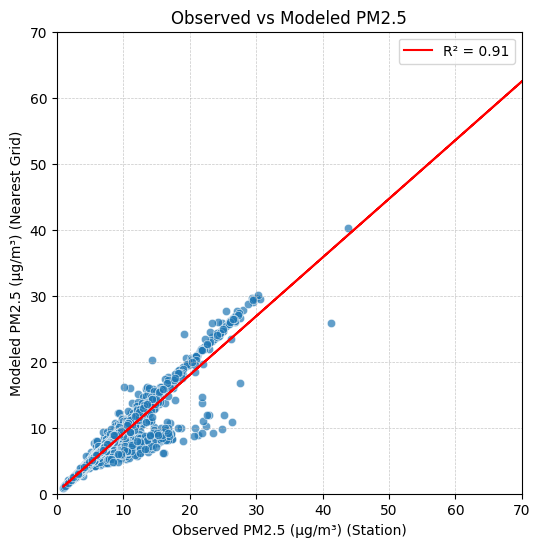

Mean Absolute Error (MAE): 0.99
Root Mean Squared Error (RMSE): 1.94


In [121]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress
from sklearn.metrics import mean_absolute_error, mean_squared_error  # Import missing functions

# Load the dataset
stations = pd.read_csv("matched_PM25_optimized.csv")

# Extract observed and modeled PM2.5 values
observed_pm25 = stations["SURF_ug_PM25_rh50"]
modeled_pm25 = stations["nearest_SURF_ug_PM25_rh50"]

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(observed_pm25, modeled_pm25)

# Calculate R-squared
r_squared = r_value**2

# Create the scatter plot with grid
plt.figure(figsize=(6, 6))
sns.scatterplot(x=observed_pm25, y=modeled_pm25, alpha=0.7)

# Plot the regression line with R² label
plt.plot(observed_pm25, slope * observed_pm25 + intercept, color='red', label=f"R² = {r_squared:.2f}")

# Labels, title, and grid
plt.xlabel("Observed PM2.5 (µg/m³) (Station)")
plt.xlim(0, 70)
plt.ylim(0, 70)
plt.ylabel("Modeled PM2.5 (µg/m³) (Nearest Grid)")
plt.title("Observed vs Modeled PM2.5")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

# Show the plot
plt.show()

# Compute error metrics
mae = mean_absolute_error(observed_pm25, modeled_pm25)
rmse = np.sqrt(mean_squared_error(observed_pm25, modeled_pm25))

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

In [123]:
import pandas as pd

# Φόρτωση των παλιών και νέων δεδομένων σταθμών
old_data = pd.read_csv("basePM25nearest_grid.csv")  # Όταν τα `lon, lat` ήταν κέντρα
new_data = pd.read_csv("matched_PM25_optimized.csv")  # Όταν τα `lon, lat` είναι γωνίες

# Υπολογισμός διαφοράς συντεταγμένων
diff_lon = new_data["nearest_lon"] - old_data["nearest_grid_lon"]
diff_lat = new_data["nearest_lat"] - old_data["nearest_grid_lat"]

print("Μέση διαφορά Lon:", diff_lon.abs().mean())
print("Μέση διαφορά Lat:", diff_lat.abs().mean())


Μέση διαφορά Lon: 0.04999999999999983
Μέση διαφορά Lat: 0.02500000000000229
